# Reading the data of ASCII XYZ datasets

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np

%matplotlib inline

In [2]:
import sys
import importlib
sys.path.append('../../modules')
from processing import interpolate
from plotting import interpolate_plotting
importlib.reload(interpolate);

# Magnetic Data

In [3]:
blocks = []
block_ids = []

with open('../../data/magnetic/PAC_MAG_NORTE/PAC_MAG_NORTE.xyz') as f:
    lines = f.readlines()

columns = lines[1].strip().split()
current_block = None

for line in lines[2:]:
    if line.startswith('line'):
        current_block = line.strip()
        continue
    values = line.strip().split()
    if len(values) == len(columns):
        blocks.append(values)
        block_ids.append(current_block)

df = pd.DataFrame(blocks, columns=columns)
df['block'] = block_ids
df;

In [4]:
df = df.astype({
    '/FID': int,
    'JDAY': int,
    'TIME': float,
    'X': float,
    'Y': float,
    'LAT': float,
    'LONG': float,
    'RAW_ALT': float,
    'ADJ_ALT': float,
    'RADAR': float,
    'TERRAIN': float,
    'DIURNAL': float,
    'IGRF': float,
    'OBSMAG': float,
    'TMI_MAG': float,
    'block': str
})

In [5]:
df_sorted = df.sort_values('X')
df_sample = df_sorted.iloc[::10].copy()
df_sample;

In [6]:
block_values = df_sample['block'].unique()
block_values;

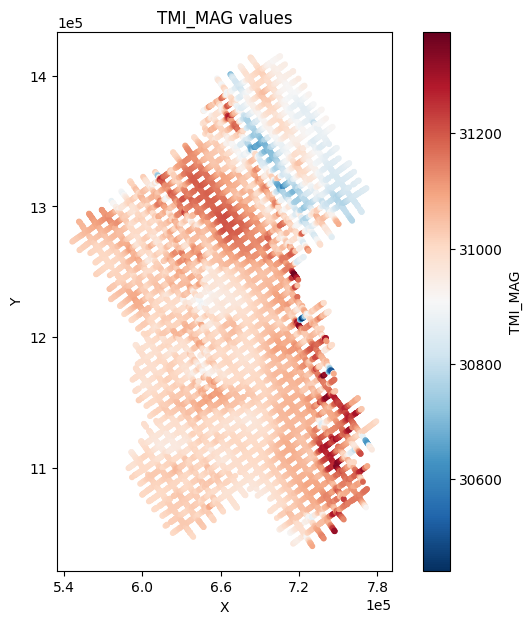

In [7]:
plt.figure(figsize=(8,7))
var = 'TMI_MAG'
vmin = df_sample[var].min()
vmax = df_sample[var].max()
plt.scatter(df_sample['X'], df_sample['Y'], cmap='RdBu_r', c=df_sample[var], s=10, vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label=var)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(5,5))
plt.ticklabel_format(style='sci', axis='y', scilimits=(5,5))
plt.title(f'{var} values')
plt.show()

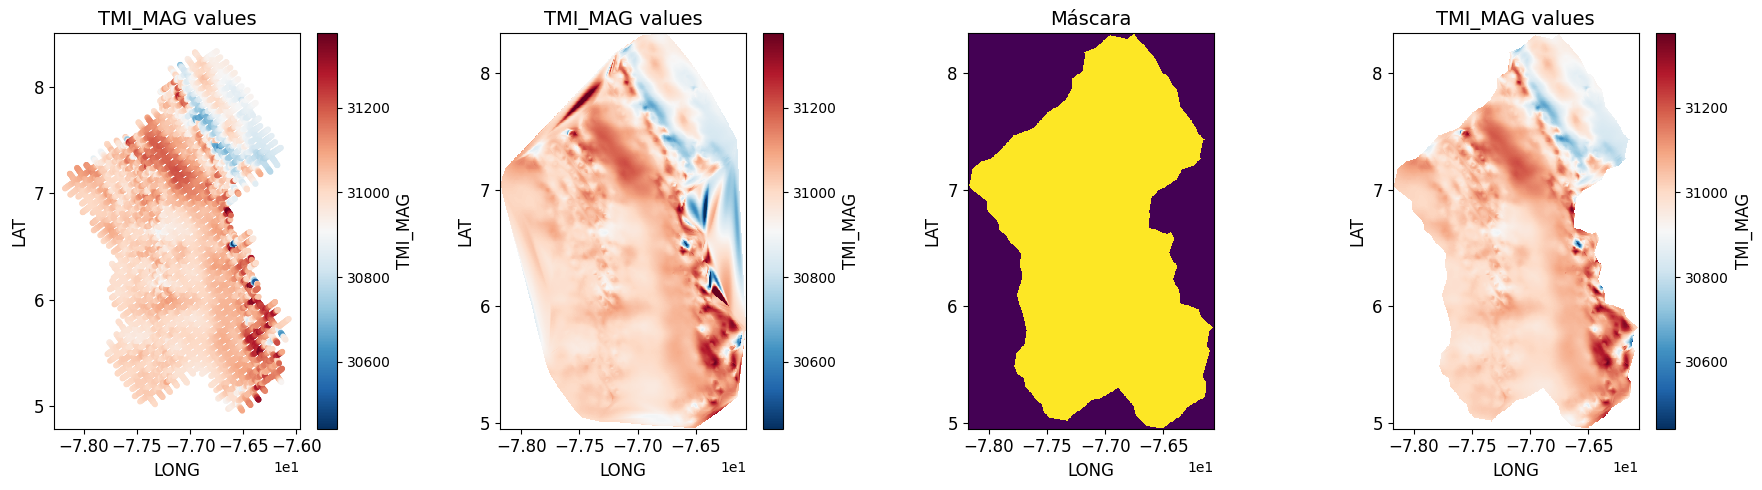

In [8]:
grid_x, grid_y, data_interpolated, data_masked, inside_mask = interpolate.interpolate_data(df_sample, 'TMI_MAG', coords_type = ('LONG', 'LAT'), alpha=10)
interpolate_plotting.plot_interpolated_data(df_sample, grid_x, grid_y, data_interpolated, data_masked, inside_mask, 'TMI_MAG', cmap='RdBu_r', coords_type = ('LONG', 'LAT'))
# plt.savefig(f'../output/figures/{var}_interpolated.png', dpi=300)

# Gravity data

In [9]:
blocks = []
block_ids = []

with open('../../data/gravity/PAC_GRAV_NORTE/PAC_GRAV_NORTE.xyz') as f:
    lines = f.readlines()

columns = lines[1].strip().split()
current_block = None

for line in lines[2:]:
    if line.startswith('line'):
        current_block = line.strip()
        continue
    values = line.strip().split()
    if len(values) == len(columns):
        blocks.append(values)
        block_ids.append(current_block)

df = pd.DataFrame(blocks, columns=columns)
df['block'] = block_ids
df;

In [10]:
df = df.astype({
    '/FID': int,
    'JDAY': int,
    'TIME': float,
    'X': float,
    'Y': float,
    'LAT': float,
    'LONG': float,
    'RAW_ALT': float,
    'ADJ_ALT': float,
    'RADAR': float,
    'TERRAIN': float,
    'RAW_VERTACC': float,
    'RAW_BEAMDIFF': float,
    'ADJSPTEN': float,
    'FACORR': float,
    'LATCORR': float,
    'RAWEOTV': float,
    'FILT_EOTV': float,
    'FREEAIR': float,
    'TCOR230': float,
    'BOUG230': float,
    'TCOR267': float,
    'BOUG267': float,
    'block': str
})

In [11]:
df_sorted = df.sort_values('X')
df_sample = df_sorted.iloc[::10].copy()
df_sample;

In [12]:
block_values = df_sample['block'].unique()
block_values;

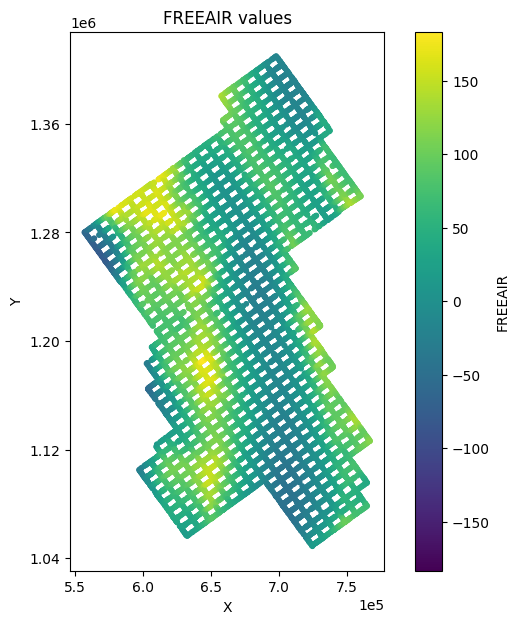

In [13]:
plt.figure(figsize=(8,7))

# var, cmap = 'FACORR', 'viridis'
# vmin = df_sample[var].min()
# vmax = df_sample[var].max()

var, cmap = 'FREEAIR', 'viridis'
# var, cmap = 'BOUG267', 'bwr'
vmax = np.abs(df_sample[var]).max()
vmin = -vmax

coords_type = ('LONG', 'LAT')

plt.scatter(df_sample['X'], df_sample['Y'], c=df_sample[var], s=10, vmin=vmin, vmax=vmax, cmap=cmap)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label=var)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(1,5))
plt.ticklabel_format(style='sci', axis='y', scilimits=(1,5))
plt.title(f'{var} values')
plt.show()

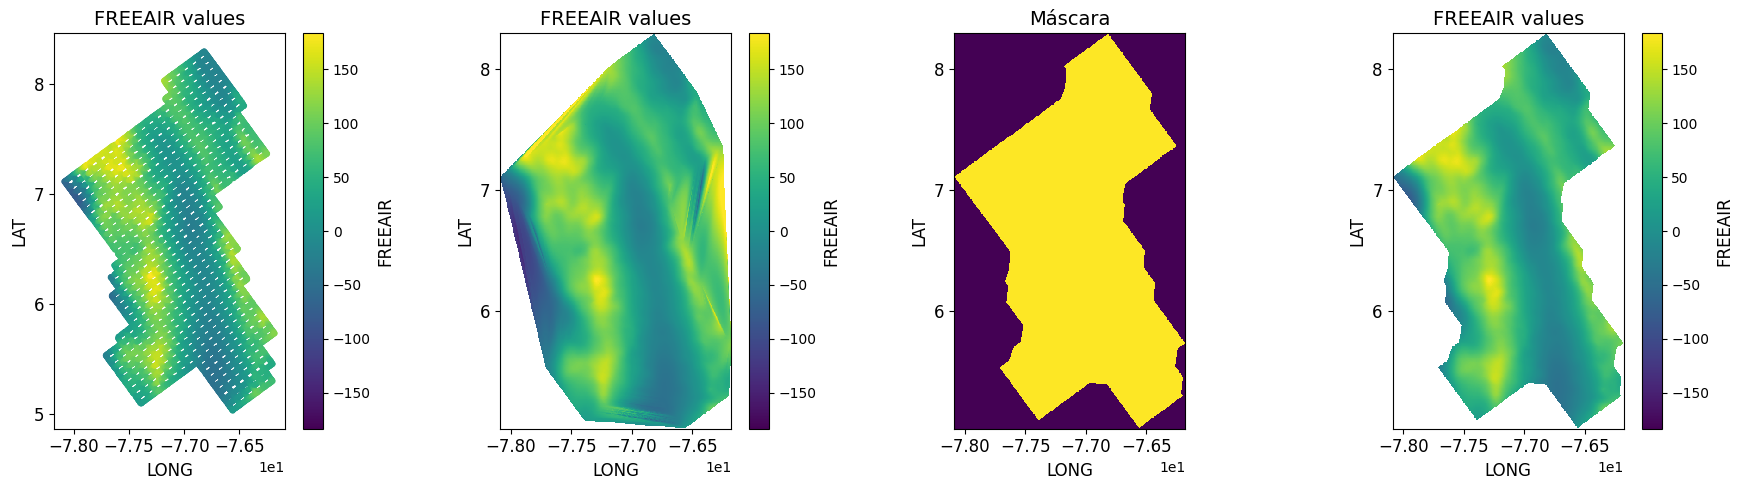

In [14]:
grid_x, grid_y, data_interpolated, data_masked, inside_mask = interpolate.interpolate_data(df_sample, var, coords_type = coords_type, alpha=10)
interpolate_plotting.plot_interpolated_data(df_sample, grid_x, grid_y, data_interpolated, data_masked, inside_mask, var, coords_type = coords_type, cmap=cmap, vmax=vmax, vmin=vmin)
# plt.savefig(f'../output/figures/{var}_interpolated.png', dpi=300)

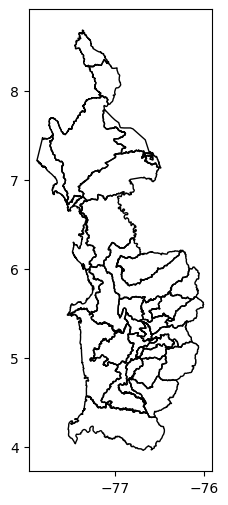

In [15]:
import geopandas as gpd
filename = '../../data/vector/colombia/Municipio, Distrito y Area no municipalizada.shp' # Data taken from colombiaenmapas.gov.co
gdf = gpd.read_file(filename)
gdf = gdf.to_crs(epsg=4326)
depto = gdf[gdf['Depto'] == 'Chocó']
depto.plot(figsize=(8,6), edgecolor='black', facecolor='none')
plt.show()

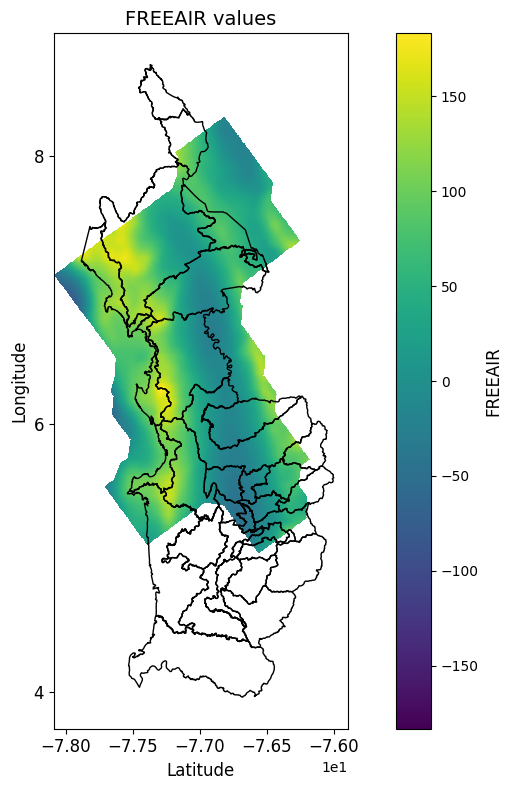

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.pcolormesh(grid_x, grid_y, data_masked.reshape((grid_x.shape)), cmap='viridis', vmin=vmin, vmax=vmax)
depto.plot(ax=ax, edgecolor='black', facecolor='none')

cb = plt.colorbar(im, ax=ax)
cb.set_label(var, fontsize=12)
ax.set_title(f'{var} values', fontsize=14)
ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
ax.set_aspect('equal', adjustable='box')
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,5))
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,5))

fig.tight_layout()
plt.show()